<a href="https://colab.research.google.com/github/sensharma/adlproject/blob/main/adlproj_adv_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls /content/gdrive/MyDrive/data

Mounted at /content/gdrive
apple_strawberry.jpg	dogs.png		   LibriSpeech
basket			FashionMNIST		   MNIST
cifar-10-batches-py	hymenoptera_data	   text_dataset_test
cifar-10-python.tar.gz	imagenet_class_index.json


In [ ]:
!ls /content/gdrive/MyDrive/colabdrive/adlproject/saved_models/

archive		    f_mnist_res_cpt_conv_chng	 mnist_checkpoint.epoch23
f_mnist_checkpoint  keras2_mnist_cnn_allconv.h5


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
data_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'data')
models_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'colabdrive', 'adlproject', 'saved_models')
plots_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'colabdrive', 'adlproject', 'plots')
scores_path = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'colabdrive', 'adlproject', 'saved_scores')

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

In [ ]:
class Net(nn.Module):
    def __init__(self, h=28, w=28, n_channels=1):
        super(Net, self).__init__()
        self.h = h
        self.w = w
        self.n_channels = n_channels

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(16, 16), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1)),
            nn.ReLU(),
            nn.Dropout(0.25),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def x_compat(self, x):
        # print(f"x - type {type(x)}")
        if type(x) is not torch.Tensor:
            x_tensor = torch.from_numpy(x)
        else:
            x_tensor = x
        x_out = x_tensor.clone().reshape(x.shape[0],
                                         self.n_channels,
                                         self.h,
                                         self.w)
        return x_out.float()

    def forward(self, x):
        if x.ndim != 4:
            # print("in compat")
            x = self.x_compat(x)
        x = self.conv_layers(x)
        # print(f"shape: {x.shape}")
        # x = x.view(-1, 1600)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [ ]:
model_file = f'{models_path}/mnist_checkpoint'
checkpoint = torch.load(model_file, map_location=device)
model = Net().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(16, 16), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1600, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [ ]:
train_dataset = datasets.MNIST(root=data_path,
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                                             transforms.ToTensor()
                                                             ])
                               )

test_dataset = datasets.MNIST(root=data_path,
                              train=False,
                              download=True,
                              transform=transforms.Compose([
                                                            transforms.ToTensor()
                                                            ])
                              )

fm_train_dataset = datasets.FashionMNIST(root=data_path,
                                         train=True,
                                         download=True,
                                         transform=transforms.Compose([
                                                                       transforms.ToTensor()
                                                                       ])
                                         )

fm_test_dataset = datasets.FashionMNIST(root=data_path,
                                        train=False,
                                        download=True,
                                        transform=transforms.Compose([
                                                                      transforms.ToTensor()
                                                                      ])
                                        )

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True,
    )

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=True,
    )

f_mnist_train_loader = torch.utils.data.DataLoader(
    dataset=fm_train_dataset,
    batch_size=1,
    shuffle=False,
    )

f_mnist_test_loader = torch.utils.data.DataLoader(
    dataset=fm_test_dataset,
    batch_size=1,
    shuffle=False,
    )

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        init_output = model(data)
        init_pred = init_output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(init_output.log(), target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        perturbed_output = model(perturbed_data).log()

        # Check for success
        final_pred = perturbed_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 20):
                orig_data = data.squeeze().detach().cpu().numpy()
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, orig_data) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 20:
                orig_data = data.squeeze().detach().cpu().numpy()
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, orig_data) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9878 / 10000 = 0.9878
Epsilon: 0.05	Test Accuracy = 9314 / 10000 = 0.9314
Epsilon: 0.1	Test Accuracy = 7494 / 10000 = 0.7494
Epsilon: 0.15	Test Accuracy = 4469 / 10000 = 0.4469
Epsilon: 0.2	Test Accuracy = 1917 / 10000 = 0.1917
Epsilon: 0.25	Test Accuracy = 710 / 10000 = 0.071
Epsilon: 0.3	Test Accuracy = 264 / 10000 = 0.0264


In [ ]:
import pickle

with open(f"{scores_path}/adv_ex_fmnist.pkl", "wb") as fp:   #Pickling
    pickle.dump(examples, fp)

In [ ]:
with open(f"{scores_path}/adv_ex_fmnist.pkl", "rb") as fp:   # Unpickling
    ex_load = pickle.load(fp)

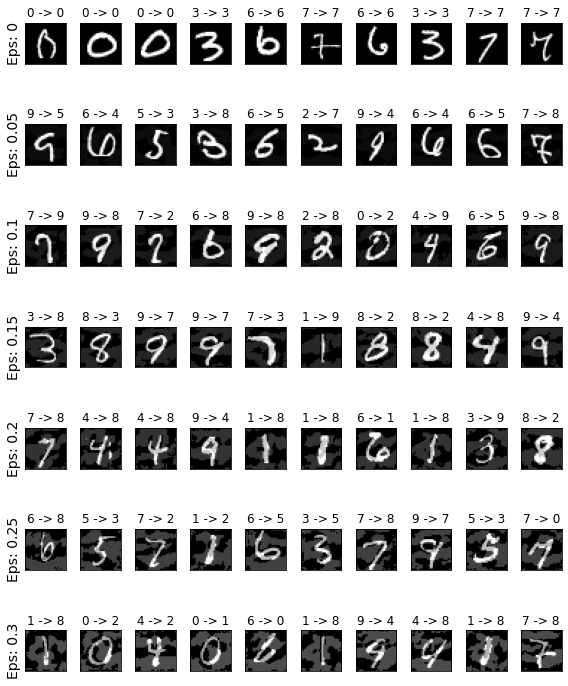

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
num_sub = 10  # dispay total - num_sub examples
for i in range(len(epsilons)):
    for j in range(len(ex_load[i])-num_sub):
        cnt += 1
        plt.subplot(len(epsilons), len(ex_load[0])-num_sub, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig_label, adv_label, pert_data, orig_data = ex_load[i][j]
        plt.title(f"{orig_label} -> {adv_label}")
        plt.imshow(pert_data, cmap="gray")
plt.tight_layout()
save = True
if save:
    plt.savefig(f"{plots_path}/adv_examples/FGSM_mnist.png")
plt.show()

<Figure size 432x288 with 0 Axes>